**Машинное обучение (семинары в записи)**

***Урок 3. Классификация на практике***

Один из способов повысить эффективность взаимодействия банка с клиентами — отправлять предложение о новой услуге не всем клиентам, а только некоторым, которые выбираются по принципу наибольшей склонности к отклику на это предложение.

Задача заключается в том, чтобы предложить алгоритм, который будет выдавать склонность клиента к положительному или отрицательному отклику на предложение банка. Предполагается, что, получив такие оценки для некоторого множества клиентов, банк обратится с предложением только к тем, от кого ожидается положительный отклик.

Создайте модель линейной регрессии, которая бы оценивала лояльность пользователей к отклику.

In [2]:
# Импорт библиотек
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
# Загрузка данных
data = pd.read_csv('sample_data/ClientsData.csv')
data.head()

,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,PERSONAL_INCOME,LOAN_NUM_TOTAL,LOAN_NUM_CLOSED,LOAN_DLQ_NUM,TARGET
0,49,1,0,1,2,1,5000.0,1,1,2,0
1,32,1,0,1,3,3,12000.0,1,1,1,0
2,52,1,0,1,4,0,9000.0,2,1,0,0
3,39,1,0,1,1,1,25000.0,1,1,3,0
4,30,1,0,0,0,0,12000.0,2,1,2,0


Пояснения к признакам набора данных:

• AGREEMENT_RK — уникальный идентификатор объекта в выборке

• TARGET — целевая переменная: отклик на маркетинговую кампанию (1 — отклик был зарегистрирован, 0 — отклика не было)

• AGE — возраст клиента

• SOCSTATUS_WORK_FL — социальный статус клиента относительно работы (1 — работает, 0 — не работает)

• SOCSTATUS_PENS_FL — социальный статус клиента относительно пенсии (1 — пенсионер, 0 — не пенсионер)

• GENDER — пол клиента (1 — мужчина, 0 — женщина)

• CHILD_TOTAL — количество детей клиента

• DEPENDANTS — количество иждивенцев клиента

• PERSONAL_INCOME — личный доход клиента (в рублях)

• LOAN_NUM_TOTAL — количество ссуд клиента

• LOAN_NUM_CLOSED — количество погашенных ссуд клиента

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15223 entries, 0 to 15222
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AGE                15223 non-null  int64  
 1   SOCSTATUS_WORK_FL  15223 non-null  int64  
 2   SOCSTATUS_PENS_FL  15223 non-null  int64  
 3   GENDER             15223 non-null  int64  
 4   CHILD_TOTAL        15223 non-null  int64  
 5   DEPENDANTS         15223 non-null  int64  
 6   PERSONAL_INCOME    15223 non-null  float64
 7   LOAN_NUM_TOTAL     15223 non-null  int64  
 8   LOAN_NUM_CLOSED    15223 non-null  int64  
 9   LOAN_DLQ_NUM       15223 non-null  int64  
 10  TARGET             15223 non-null  int64  
dtypes: float64(1), int64(10)
memory usage: 1.3 MB


In [5]:
data.duplicated().sum()

2819

In [6]:
df = data.drop_duplicates()

In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

,0
AGE,0
SOCSTATUS_WORK_FL,0
SOCSTATUS_PENS_FL,0
GENDER,0
CHILD_TOTAL,0
DEPENDANTS,0
PERSONAL_INCOME,0
LOAN_NUM_TOTAL,0
LOAN_NUM_CLOSED,0
LOAN_DLQ_NUM,0


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,12404.0,41.456304,11.541404,21.0,32.0,41.0,51.0,67.0
SOCSTATUS_WORK_FL,12404.0,0.899065,0.301255,0.0,1.0,1.0,1.0,1.0
SOCSTATUS_PENS_FL,12404.0,0.153096,0.360094,0.0,0.0,0.0,0.0,1.0
GENDER,12404.0,0.643099,0.479105,0.0,0.0,1.0,1.0,1.0
CHILD_TOTAL,12404.0,1.163254,1.025295,0.0,0.0,1.0,2.0,10.0
DEPENDANTS,12404.0,0.655353,0.833935,0.0,0.0,0.0,1.0,7.0
PERSONAL_INCOME,12404.0,14106.510025,9620.496226,24.0,8000.0,12000.0,17000.0,250000.0
LOAN_NUM_TOTAL,12404.0,1.456546,0.851157,1.0,1.0,1.0,2.0,11.0
LOAN_NUM_CLOSED,12404.0,0.829329,1.039791,0.0,0.0,1.0,1.0,11.0
LOAN_DLQ_NUM,12404.0,0.233957,0.749805,0.0,0.0,0.0,0.0,13.0


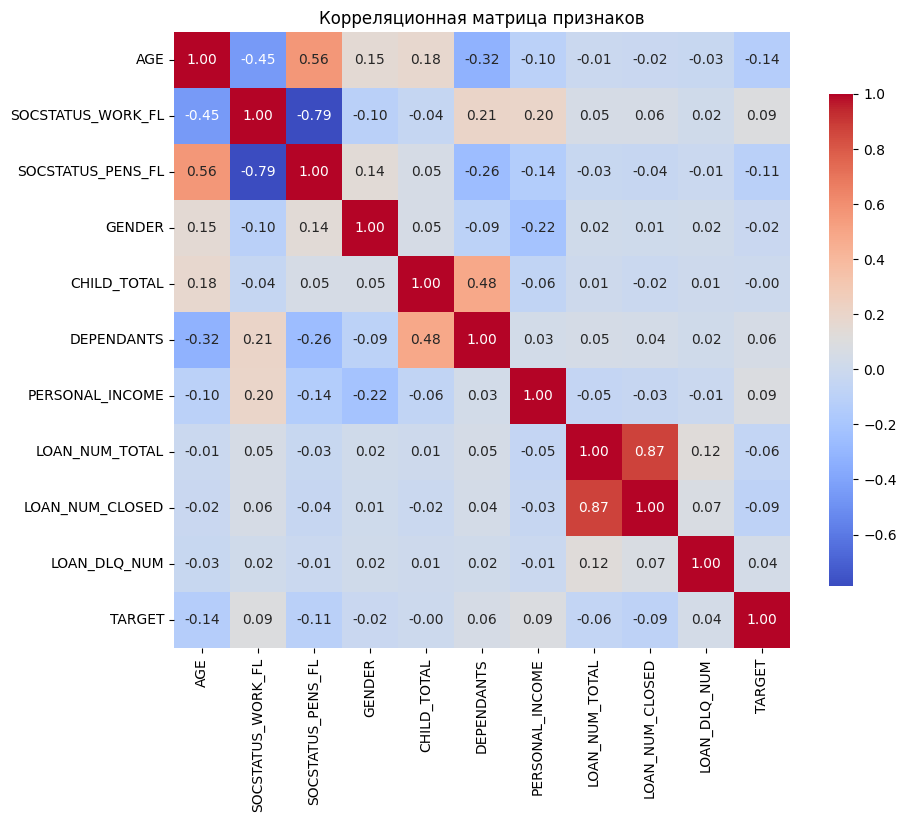

In [10]:
# Вычисляем корреляционную матрицу
correlation_matrix = df.corr()

# Настраиваем размер графика
plt.figure(figsize=(10, 8))

# Создаем тепловую карту
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f", cbar_kws={"shrink": .8})

# Добавляем заголовок
plt.title('Корреляционная матрица признаков')

# Показываем график
plt.show()

Анализ корреляционной матрицы показывает, что зависимость между признаками и целевой переменной практически отсутствует, что говорит о том, что модель скорее всего построить не получится - она не будет работать!

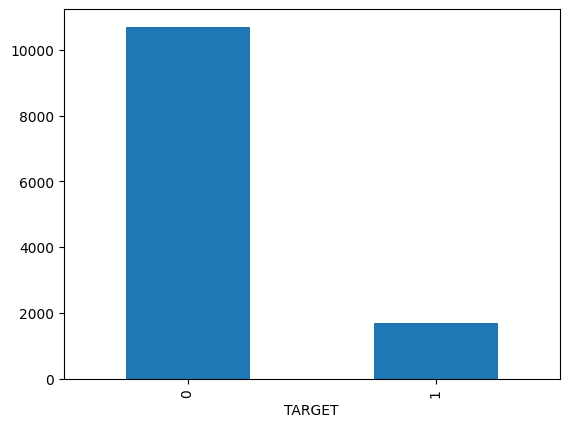

In [11]:
df.TARGET.value_counts().plot(kind='bar');

Наблюдаем сильный дисбаланс по целевой переменной.

In [12]:
# Определение зависимой и независимых переменных
X = df.drop('TARGET', axis=1)  # Независимые переменные
y = df['TARGET']  # Зависимая переменная

In [13]:
# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Масштабируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Создание и обучение модели линейной регрессии:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [16]:
# Оценка производительности модели
score = model.score(X_test_scaled, y_test)  # Коэффициент детерминации R²
coefficients = model.coef_  # Коэффициенты регрессии
intercept = model.intercept_  # Свободный член

print("Производительность модели (R²):", score)
print("Коэффициенты регрессии:", coefficients)
print("Свободный член:", intercept)

Производительность модели (R²): 0.042790640477441855
Коэффициенты регрессии: [-0.03790583  0.00432176 -0.00844885  0.00149779  0.00892913 -0.00069575
  0.02732322  0.01598683 -0.04412725  0.01056607]
Свободный член: 0.13806308576035473


**Вывод**

***Анализ результатов модели линейной регрессии***

1. Коэффициент детерминации (R²)
- Значение R²: 0,0428
- Это значение указывает на то, что модель объясняет лишь около 4,28% вариаций целевой переменной (лояльности пользователей). Это довольно низкий показатель, что может свидетельствовать о следующем: модель не полностью захватывает зависимости в данных, данные могут содержать шум или быть недостаточно информативными.
2. Коэффициенты регрессии
- Коэффициенты регрессии показывают, как изменение каждой независимой переменной влияет на зависимую переменную (лояльность).
- Получившиеся коэффициенты: [-0.0379, 0.0043, -0.0084, 0.0015, 0.0089, -0.0007, 0.0273, 0.0160, -0.0441, 0.0106]
- Отрицательные коэффициенты (например, -0,0379 и -0,0441) указывают на то, что увеличение соответствующей независимой переменной связано с уменьшением лояльности пользователей.
- Положительные коэффициенты (например, 0,0043 и 0,0273) указывают на то, что увеличение соответствующей переменной связано с повышением лояльности.
3. Свободный член
- Свободный член: 0,1381
- Это значение представляет собой среднее значение целевой переменной при условии, что все независимые переменные равны нулю.

**ИТОГ**

***Анализ результатов модели показал, что в представленном виде она не может быть использована, что, в общем и целом, подтвердило выводы, сделанные по результатам построения матрицы корреляции.***

Из рекомендаций по улучшению модели можно предложить следующее:
1. Добавить новые признаки:
- проанализировать данные на предмет дополнительных факторов, которые могут влиять на лояльность пользователей;
- попробовать создать новые признаки из существующих.
2. Попробовать применить другие существующие модели:
- линейная регрессия может оказаться не лучшим выбором для представленного набора данных;
- целесообразно рассмотреть возможность использования более сложных моделей, таких как деревья решений, случайный лес или градиентный бустинг.
3. Возможно, нужна дополнительная предобработка данных: например, убедиться, что категориальные переменные закодированы правильно.
4. Использовать кросс-валидацию.